In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np 
import random

In [30]:
env = gym.make('Blackjack-v1')
state, _ = env.reset()
done = False
episode_rewards = []

while not done:
    state_tensor = torch.FloatTensor(state)
    print('STATE: ', state)
    
    # Estrategia aleatoria para demostración
    action = random.randint(0, 1)
    print('ACTION: ', action)
    
    next_state, reward, terminated, truncated, info = env.step(action)
    print('REWARD: ', reward)
    episode_rewards.append(reward)
    print(info)

    if terminated:
        print(info)
        done = True
        print('FINAL STATE:', state)
        
    next_state_tensor = torch.FloatTensor(next_state)
    state = next_state

# Imprime la recompensa total de la partida
print('TOTAL REWARD: ', sum(episode_rewards))

STATE:  (20, 5, 0)
ACTION:  1
REWARD:  -1.0
{}
{}
FINAL STATE: (20, 5, 0)
TOTAL REWARD:  -1.0


In [3]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, action_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.network(state)

In [4]:
# Define la red neuronal para el crítico
class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.network(state)

In [5]:
def train_model(env, actor, critic, actor_optimizer, critic_optimizer, num_episodes, gamma=0.99):
    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_rewards = []

        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = actor(state_tensor)
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_rewards.append(reward)

            if terminated or truncated:
                done = True

            value = critic(state_tensor)
            next_state_tensor = torch.FloatTensor(next_state)
            next_value = critic(next_state_tensor)
            target = reward + (gamma * next_value * (1 - int(done)))
            critic_loss = (target - value).pow(2)

            actor_loss = -torch.log(action_probs[action]) * (target - value).detach()

            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            state = next_state

        total_rewards.append(sum(episode_rewards))
    return total_rewards

In [6]:
env = gym.make('Blackjack-v1')
action_size = env.action_space.n

In [7]:
actor = Actor(3, action_size)
critic = Critic(3)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [8]:
total_rewards = train_model(env, actor, critic, actor_optimizer, critic_optimizer, 1000)

In [9]:
def evaluate_agent(env, actor, num_episodes):
    total_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state)
            action_probs = actor(state_tensor)
            action = torch.argmax(action_probs).item()

            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                done = True

        total_rewards.append(total_reward)

    return np.mean(total_rewards)

In [10]:
print("Evaluación del Agente:", evaluate_agent(env, actor, 100))

Evaluación del Agente: -0.21


In [11]:
def plot_rewards(total_rewards, window=50):
    plt.figure(figsize=(12, 6))

    # Ploteando las recompensas individuales como puntos
    plt.scatter(range(len(total_rewards)), total_rewards, label='Recompensa por Episodio', alpha=0.6, s=10)

    # Calculando y ploteando el promedio móvil
    moving_avg = np.convolve(total_rewards, np.ones(window)/window, mode='valid')
    plt.plot(np.arange(window-1, len(total_rewards)), moving_avg, label=f'Promedio Móvil ({window} episodios)', color='orange', linewidth=2)

    # Calculando y ploteando la acumulación de recompensas
    cumulative_rewards = np.cumsum(total_rewards)
    plt.plot(cumulative_rewards, label='Acumulación de Recompensas', color='green', linewidth=2)

    # Añadiendo título y etiquetas
    plt.title("Recompensas por Episodio con Promedio Móvil y Acumulación")
    plt.xlabel("Episodios")
    plt.ylabel("Recompensa Total")

    # Añadiendo leyenda y grid
    plt.legend()
    plt.grid(True)

    # Mostrando el gráfico
    plt.show()


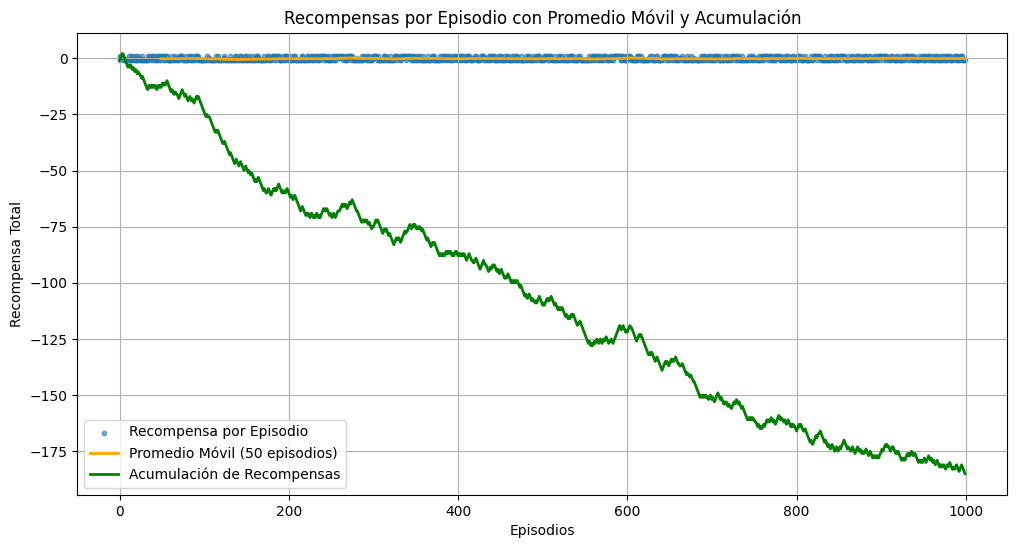

In [12]:
plot_rewards(total_rewards)
env.close()